In [4]:
import os
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [93]:
class RunnerResults:
    def __init__(self, line):
        fields = line.split(',')
        self.name = fields[0]
        self.cores = int(fields[1])
        self.min_threads = int(fields[2])
        self.max_threads = int(fields[3])
        self.n = fields[4]
        self.inserts = fields[5]
        self.removals = fields[6]
        self.lookups = fields[7]
        self.scaling_mode = fields[8]
        self.with_affinity = True if fields[9] == 'true' else False
        self.preload = float(fields[10])
        length = len(fields)
        self.run_times = []
        for t in fields[11:]:
            self.run_times.append(float(t))
 
def find_mapload(fname):
    index = fname.find("_u")
    if index != -1:
        load_start = fname[index + 2:]
        return load_start[:load_start.find("_")]
    
def get_results(data_path):
    file_names = [fname for fname in os.listdir(data_path) if fname[0] != '.']
    results_list = []
    for fname in file_names:
        results = {}
        for line in open(os.path.join(data_path, fname), 'r').readlines():
            line = line.strip()
            if not len(line) or line.startswith(('#', 'list')):
                continue
            rr = RunnerResults(line)
            ld = find_mapload(fname)
            rr.mapLoad = ld
            results[rr.name] = rr
        results_list.append(results)
    return results_list
                

In [100]:
results = get_results('../../data/latedays/')

In [101]:
def get_list_speedup(results_dict):
    if 'Dllist' in results_dict:
        base_time = results_dict['DlList'].run_times[0]
    elif 'DlListMap' in results_dict:
        base_time = results_dict['DlListMap'].run_times[0]
    else:
        print 'Error: No serial version'
        exit(1)
    speedup_info = []
    for key in results_dict:
        if key in ('CoarseGrainList', 'FineGrainList', 'NonBlockingList', 'LockFreeList', 'CoarseGrainListMap', 'FineGrainListMap', 'LockFreeListMap', 'LibCuckooHashMap', 'TbbHashMap'):
            speedup_times = [base_time/rt for rt in results_dict[key].run_times]
            speedup_info.append((key, speedup_times))
    return speedup_info

def get_run_parameters(results_dict):
    if 'Dllist' in results_dict:
        r = results_dict['DlList']
        title = 'List Benchmark\n'
        title += "n=" + r.n + ", i=" + r.inserts + ", r=" + r.removals + ", l=" + r.lookups
    elif 'DlListMap' in results_dict:
        r = results_dict['DlListMap']
        title = 'Hashmap Benchmark\n'
        title += "n=" + r.n + ", i=" + r.inserts + ", r=" + r.removals + ", l=" + r.lookups + ", lf=" + r.mapLoad
    else:
        print 'Error: No serial version'
        exit(1)

    return title

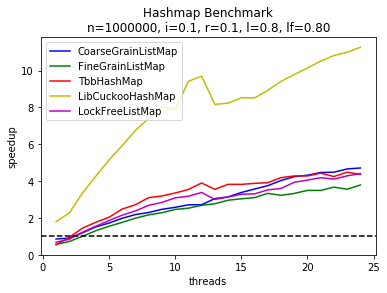

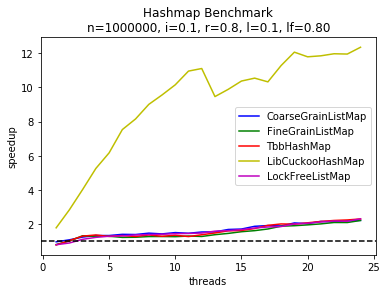

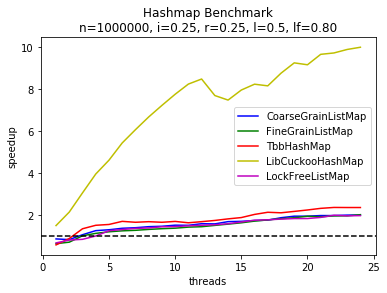

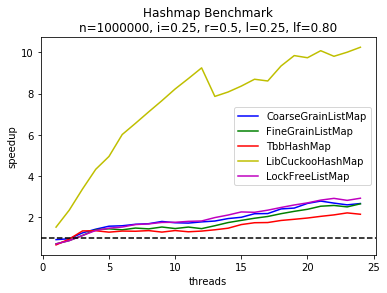

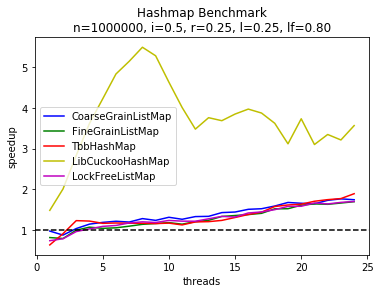

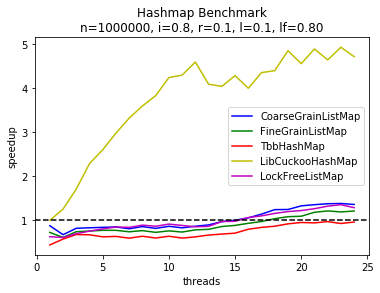

In [102]:
color_map = {'CoarseGrainList': 'b-', 'FineGrainList': 'g-', 'NonBlockingList': 'y-', 'LockFreeList': 'm-', 'CoarseGrainListMap': 'b-', 'FineGrainListMap': 'g-', 'LockFreeListMap': 'm-', 'LibCuckooHashMap': 'y-', 'TbbHashMap': 'r' }
for run in results:
    speedup_times = get_list_speedup(run)
    thread_counts = range(1, len(speedup_times[0][1])+1)
    title = get_run_parameters(run)
    for name, st in speedup_times:
        plt.plot(thread_counts,st, color_map[name], label=name)
    plt.title(title)
    plt.ylabel('speedup')
    plt.xlabel('threads')
    plt.legend(loc='best')
    plt.axhline(y=1, color='k', linestyle='--')
    plt.show()